# Coherence Analysis

## Approach 1: Using Semantic Similarity Graph
Implementation of Semantic Similarity Graph based on Putra et al. Class use to compute the coherence of a given text


## Approach 2: Using Neural Network 
Utilizing LSTM and fine-tuned BERT architecture to generate a coherence score for song lyrics. The architecture will be train on real world lyrics and then compared it to generated lyrics by other ML tasks. 

In [ ]:
!pip install gensim
!pip install nltk
!pip install transformer
!pip install networkx
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)
ERROR: No matching distribution found for transformer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import relevant libraries
import re
import random
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import networkx as nx


# import nltk and gensim library for token level embeddings
import nltk
import gensim
import gensim.downloader
from nltk.data import find


### Preparing Preprocessing Tools
Before we can start analzing the coherence of our text, we need to set up a way to tokenize the input. We will be using [NLTK punkt module](https://www.nltk.org/api/nltk.tokenize.punkt.html) to tokenize the sentences in our dataset. In Putra et al. the research group used a pretrained GloVe word vector to project a sentence into a vector representation. It is noted that a sentence consists of multiple words {w1, w2, w3, ..., wn } where each word is mapped to a vector space. We'll do the same to keep it consistent with the original intention. A future research in the field involves utilizing other embedding models such as word2vec, Elmo, etc.

In [ ]:
# load in punkt module
# instantiate the tokenizer
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
gloVe_embedder = gensim.downloader.load('glove-wiki-gigaword-50')
gloVe_embed_vectors_vocab = gloVe_embedder.vocab.keys()
len(gloVe_embed_vectors_vocab)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[==================================================] 100.0% 66.0/66.0MB downloaded


400000

In [ ]:
#@title Word2Vec Embedding Matrix Creation
# instantiate Word2Vec token level embedding
nltk.download('word2vec_sample')
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

# let's try 300 dimension Word2Vec Embedding
EMBEDDING_DIM = 300
# initialize embedding matrix and word-to-id map:
# embedding_matrix = np.zeros((len(model.key_to_index) + 1, EMBEDDING_DIM))       
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       

word2Vec_embedder = {}
# build the embedding matrix and the word-to-id map:
# for i, word in enumerate(model.key_to_index):
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        word2Vec_embedder[word] = embedding_vector

# we can use the last index at the end of the vocab for unknown tokens
word2Vec_embedder['[UNK]'] = np.zeros(EMBEDDING_DIM)
embedding_matrix.shape

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


(43982, 300)

In [ ]:
# preparing preprocessing tools
def text_to_tokens(text):
  """
    Process input text into individual token per sentence
  """
  processed_lyric_tokenzied = [i.lower().replace(',', '').split() for i in text.split("\n")]
  
  return processed_lyric_tokenzied

def tokens_to_vectors(sentences, embedder=word2Vec_embedder):
  """
    Process each token into it embedded vector using pre-trained embedder
    If the word is not in corpus, replace with embedding of unknown token
  """

  embedded_matrix = []
  for s in sentences:
    word_embedding_arr = []
    for word in s:
      try:
        word_embedding_arr.append(embedder[word])
      except:
        word_embedding_arr.append(embedder['[UNK]'])
    embedded_matrix.append(word_embedding_arr)

  return embedded_matrix

In [ ]:
class SemanticGraph():
  """
    Semantic Similar Graph Implementation
  """
  def __init__(self, data=None):
    self.lemma = []
    self.vectors = []
    self.G = None

    if data != None:
      self.set_document(data)

  def build_graph(self):
    self.G = nx.DiGraph()
    self.set_nodes()
    self.set_edges()


  def set_document(self, text):
    """
      Tokenize and embedd the tokens
      Load the document into the system
      Generate a node for each token index
    """
    document = {
        'lemma': [],
        'vectors': []
    }
    document['lemma'] = text_to_tokens(text)
    embeddings = tokens_to_vectors(text_to_tokens(text))
    vectors = [np.mean(embedding, axis=0) for embedding in embeddings]
    document['vectors'] = vectors
    self.lemma = document['lemma']
    self.vectors = document['vectors']
    self.build_graph()


  def set_nodes(self):
    """
      Generate a node per sentence in the stored dictionary
    """
    for idx, sentence in enumerate(self.lemma):
      self.G.add_node(idx)


  def set_edges(self):
    """
      Class Abstract Function
    """
    pass


  def print(self):
    """
      Print the graph in the console
    """
    labels = nx.get_edge_attributes(self.G, 'weight')
    for key in labels:
      labels[key] = round(labels[key], 3)
    pos = nx.spring_layout(self.G)
    nx.draw(self.G, pos, with_labels=True, font_weight='bold')
    nx.draw_networkx_edge_labels(self.G, pos, edge_labels=labels)


  def evaluate_coherence(self):
    """
      Compute coherence score the entire document
      Based on Putra et al.
        - Average over number of sentences, and number of outgoing edges weights
    """
    labels = nx.get_edge_attributes(self.G, 'weight')
    if len(labels.keys()) == 0:
      return 0
    return np.mean(np.array(list(labels.values())))

In [ ]:
from scipy import spatial

class PAV(SemanticGraph):

    def __init__(self):
        # Inherit the Semantic Graph Class
        # super().__init__(self)
        self.alpha = 0


    def set_alpha(self, _alpha):
        self.alpha = _alpha
        self.build_graph()


    def set_edges(self):
        """
            Polymorp the set_edges method
            Define coherence as previous sentences give context to current sentence
            For PAV:
                1. compute the cosine similarity of setence pairs
                2. Compute Unique Overlapping Terms (UOT)

        """
        i = len(self.vectors) -1
        while i > 0:
            # cosine similarity
            cosine = 1 - spatial.distance.cosine(self.vectors[i], self.vectors[i - 1])
            
            # for two sentences, determine the UOT
            terms1 = set(self.lemma[i])
            terms2 = set(self.lemma[i - 1])
            unique = terms1.intersection(terms2)
            common = terms1.union(terms2)
            uot = 1.0 * len(unique) / len(common)

            # compute the weight
            weight = self.alpha * uot + (1 - self.alpha) * cosine
            self.G.add_weighted_edges_from([(i, i - 1, weight)])
            i -= 1


In [ ]:
class SSV(SemanticGraph):
    def __init__(self):
        #super().__init__(self)
        pass

    def set_edges(self):
        """
            Polymorp the set_edges method
            Define coherence as the dependency among sentences
            For SSV:
                1. compute the weight as cosine similarity
        """
        i = 0

        # for each sentence, 
        # loop through each other sentence to compute the weight
        while i < len(self.lemma):
          j = 0

          current_related_idx = -1
          current_related_weight = 0
          while j < len(self.lemma):
            # if the same sentence, simply ignore
            if i == j:
                j += 1
                continue
            

            # compute the weight of both sentence
            # the weights are penalized by the distance between two senteces (closer sentences are more prefer)
            # keep only the most similar sentence among all sentences in a given text
            weight = (1 - spatial.distance.cosine(self.vectors[i], self.vectors[j]) / abs(i-j))
            if weight > current_related_weight:
                current_related_weight = weight
                current_related_idx = j
            j += 1
            if j == len(self.lemma):
              print(f"{i}: Completed Sentence")

          # update weights between two sentence nodes
          # go to next sentence
          self.G.add_weighted_edges_from([(i, current_related_idx, current_related_weight)])
          i += 1


In [ ]:
class MSV(SemanticGraph):
    def __init__(self):
        #super().__init__(self)
        self.theta = 0


    def set_theta(self, _theta):
        self.theta = _theta
        self.build_graph()


    def set_edges(self):
        """
            Polymorp the set_edges method
            Define coherence as the dependency among sentences
            Similar to SSV but allow for multiple outgoing edges
            For MSV:
                1. compute the weight as cosine similarity
        """
        i = 0
        while i < len(self.lemma):
            j = 0
            while j < len(self.lemma):
                if i == j:
                    j += 1
                    continue

                # compute cosine similarity weight between current sentence and all other sentences in the document
                # the weights are penalized by the distance between two senteces (closer sentences are more prefer)
                # if a the weight is high and pass a certain threshold, that edge is created
                weight = (1 - spatial.distance.cosine(self.vectors[i], self.vectors[j])) / (abs(i - j))
                if weight > self.theta:
                    self.G.add_weighted_edges_from([(i, j, weight)])
                j += 1
            i += 1

In [ ]:
input_text = """
George Washington February 22, 1732 – December 14, 1799 was an American military officer, statesman, and Founding Father who served as the first president of the United States from 1789 to 1797 
Appointed by the Continental Congress as commander of the Continental Army, Washington led the Patriot forces to victory in the American Revolutionary War and served as the president of the Constitutional Convention of 1787 
which created the Constitution of the United States and the American federal government 
Washington has been called the Father of his Country for his manifold leadership in the formative days of the country
"""
input_text

'\nGeorge Washington February 22, 1732 – December 14, 1799 was an American military officer, statesman, and Founding Father who served as the first president of the United States from 1789 to 1797 \nAppointed by the Continental Congress as commander of the Continental Army, Washington led the Patriot forces to victory in the American Revolutionary War and served as the president of the Constitutional Convention of 1787 \nwhich created the Constitution of the United States and the American federal government \nWashington has been called the Father of his Country for his manifold leadership in the formative days of the country\n'

In [ ]:
# input_text = """
# we recommend modifying the cap to forty percent for all store division-combinations,
# for every division in the 239 stores the new cap is forty percent
# """
# input_text

'\nwe recommend modifying the cap to forty percent for all store division-combinations,\nfor every division in the 239 stores the new cap is forty percent\n'

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


PAV - coherence: 0.431851175753127, alpha: 0.6


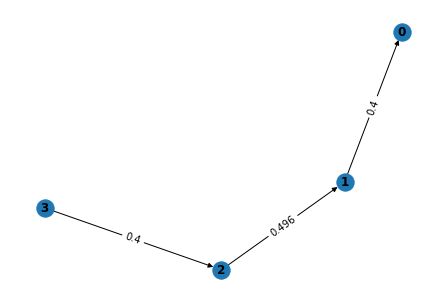

In [ ]:
alpha = 0.6
pav = PAV()
pav.set_document(input_text)
pav.set_alpha(alpha)
print("PAV - coherence: {0}, alpha: {1}".format(pav.evaluate_coherence(), alpha))
pav.print()

0: Completed Sentence
1: Completed Sentence
2: Completed Sentence
SSV - coherence: 1.0


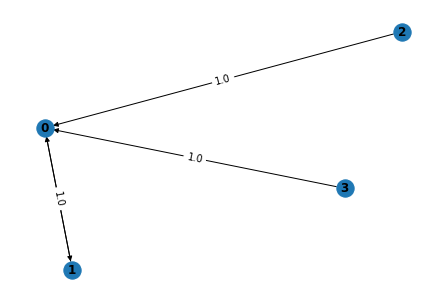

In [ ]:
ssv = SSV()
ssv.set_document(input_text)
print("SSV - coherence: {0}".format(ssv.evaluate_coherence()))
ssv.print()

MSV - coherence: 0.6962467182294204, theta: 0.2


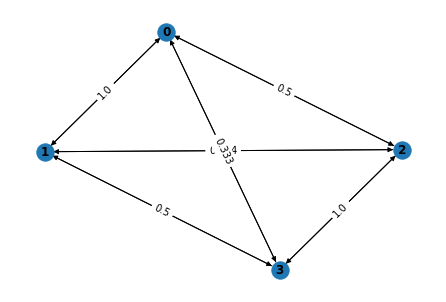

In [ ]:
theta = 0.2
msv = MSV()
msv.set_document(input_text)
msv.set_theta(theta)
print("MSV - coherence: {0}, theta: {1}".format(msv.evaluate_coherence(), theta))
msv.print()